<a href="https://colab.research.google.com/github/vasanthbhagawat-source/Ensembled/blob/main/finalmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ✅ STEP 2: Install Required Packages
!pip install -q keras scikit-learn matplotlib seaborn opencv-python
!pip install tensorflow

In [ ]:
# STEP 3: Set Paths and Create Result Directory
import os
train_dir = '/content/drive/MyDrive/alex/Brain/Training'
test_dir = '/content/drive/MyDrive/alex/Brain/Testing'
save_dir = '/content/drive/MyDrive/alex/brain_tumor_results'
os.makedirs(save_dir, exist_ok=True)


In [ ]:
# STEP 4: Data Augmentation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# STEP 5: Define All 4 Models
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
num_classes = train_gen.num_classes
def resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
def create_mesresnet50_v2():
    """
    Restructures the ResNet50 architecture for increased accuracy through
    fine-tuning and a more robust classifier head.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last 50 layers for fine-tuning
    for layer in base_model.layers[:20]:
        layer.trainable = False

    # Build the new classifier head using the Functional API for more flexibility
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
   # x = layers.BatchNormalization()(x)
   # x = layers.Dense(1024)(x)
   # x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs= layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_alexnet():
    model = models.Sequential([
        layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(256, (5,5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(384, (3,3), activation='relu', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model




In [ ]:
# STEP 6: Compile and Train Function
def compile_and_train(model, name):
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=20)
    model.save(f'{save_dir}/{name}.h5')
    return model, history


In [ ]:
# STEP 7: Train All Models
models_dict = {}
histories = {}

for name, builder in {
    "MesResNet50": create_mesresnet50_v2,
    "CNN": create_cnn,
    "AlexNet": create_alexnet,
    "VGG16": create_vgg16,
    "ResNet50": resnet50
}.items():
    print(f"\nTraining {name}...")
    model, history = compile_and_train(builder(), name)
    models_dict[name] = model
    histories[name] = history



Training MesResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1161s 8s/step - accuracy: 0.5188 - loss: 1.3143 - val_accuracy: 0.2314 - val_loss: 3.2743
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.8313 - loss: 0.4974 - val_accuracy: 0.3418 - val_loss: 4.4518
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.8612 - loss: 0.4271 - val_accuracy: 0.6503 - val_loss: 1.1654
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.8971 - loss: 0.3113 - val_accuracy: 0.8309 - val_loss: 0.6194
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9143 - loss: 0.2497 - val_accuracy: 0.9106 - val_loss: 0.3015
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9350 - loss: 0.1757 - val_accuracy: 0.7195 - val_loss: 0.9534
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9397 - loss: 0.1751 - val_accuracy: 0.8677 - val_loss: 0.4080
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.9460 - loss: 0.


Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 553ms/step - accuracy: 0.4420 - loss: 1.1850 - val_accuracy: 0.6363 - val_loss: 1.0028
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.7119 - loss: 0.7463 - val_accuracy: 0.5898 - val_loss: 1.0195
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.7403 - loss: 0.6690 - val_accuracy: 0.7064 - val_loss: 0.9818
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.7456 - loss: 0.6400 - val_accuracy: 0.6740 - val_loss: 0.8504
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 479ms/step - accuracy: 0.7650 - loss: 0.6084 - val_accuracy: 0.6748 - val_loss: 0.8681
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.7766 - loss: 0.5775 - val_accuracy: 0.7020 - val_loss: 0.8566
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.7864 - loss: 0.5601 - val_accuracy: 0.7038 - val_loss: 0.8689
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 477ms/step - accuracy: 0.7923 - loss: 0


Training AlexNet...
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 604ms/step - accuracy: 0.3410 - loss: 1.2545 - val_accuracy: 0.5162 - val_loss: 1.0628
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.6024 - loss: 0.8612 - val_accuracy: 0.5837 - val_loss: 0.9537
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.7071 - loss: 0.6838 - val_accuracy: 0.7160 - val_loss: 0.7653
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.7728 - loss: 0.5570 - val_accuracy: 0.7432 - val_loss: 0.6909
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.8197 - loss: 0.4566 - val_accuracy: 0.7336 - val_loss: 0.7215
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - accuracy: 0.8354 - loss: 0.4370 - val_accuracy: 0.7467 - val_loss: 0.6769
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - accuracy: 0.8477 - loss: 0.3796 - val_accuracy: 0.8098 - val_loss: 0.5585
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 503ms/step - accur


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 630ms/step - accuracy: 0.5955 - loss: 0.9498 - val_accuracy: 0.7117 - val_loss: 0.7300
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.8299 - loss: 0.4733 - val_accuracy: 0.7458 - val_loss: 0.6320
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - accuracy: 0.8572 - loss: 0.4187 - val_accuracy: 0.7686 - val_loss: 0.6289
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 500ms/step - accuracy: 0.8676 - loss: 0.3688 - val_accuracy: 0.7432 - val_loss: 0.6714
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 499ms/step - accuracy: 0.8672 - loss: 0.3546 - val_accuracy: 0.7739 - val_loss: 0.5962
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 500ms/step - accuracy: 0.8808 - loss: 0.3276 - val_accuracy: 0.8054 - val_loss: 0.5373
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 498ms/step - accuracy: 0.8874 - loss: 0.3374 - val_accuracy: 0.7993 - val_loss: 0.5555
Epoch 8/20
14


Training ResNet50...
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 113s 645ms/step - accuracy: 0.5762 - loss: 0.9614 - val_accuracy: 0.2349 - val_loss: 2.0961
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.6997 - loss: 0.7322 - val_accuracy: 0.4400 - val_loss: 1.8083
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 513ms/step - accuracy: 0.7216 - loss: 0.6650 - val_accuracy: 0.5083 - val_loss: 2.2776
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.7293 - loss: 0.6414 - val_accuracy: 0.5521 - val_loss: 1.1478
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 505ms/step - accuracy: 0.7332 - loss: 0.6308 - val_accuracy: 0.5478 - val_loss: 1.3204
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.7712 - loss: 0.5556 - val_accuracy: 0.6389 - val_loss: 0.9120
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.7736 - loss: 0.5623 - val_accuracy: 0.7038 - val_loss: 0.8632
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 514ms/step - acc

Evaluating MesResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step


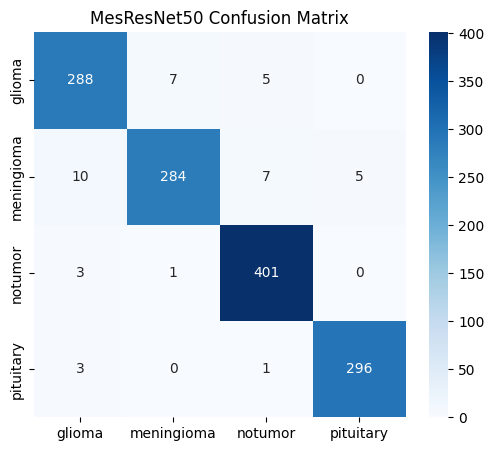

Evaluating CNN
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step


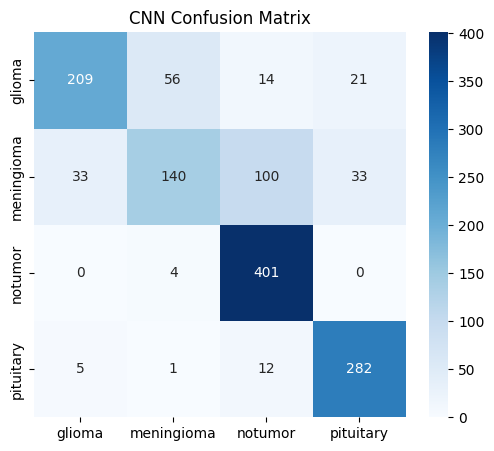

Evaluating AlexNet
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step


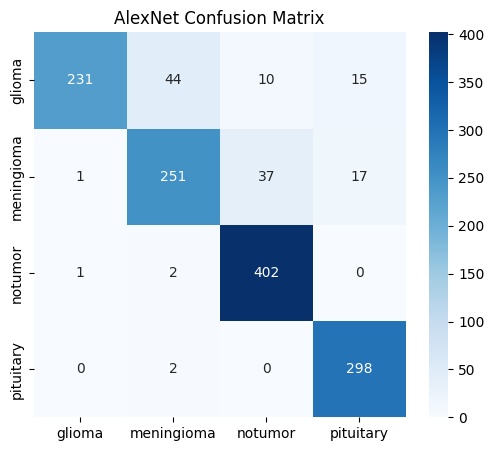

Evaluating VGG16
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step


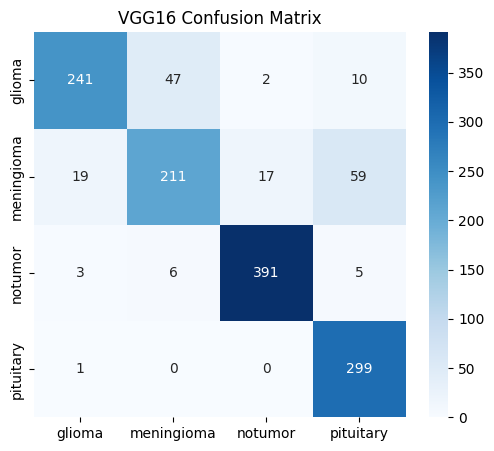

Evaluating ResNet50
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step


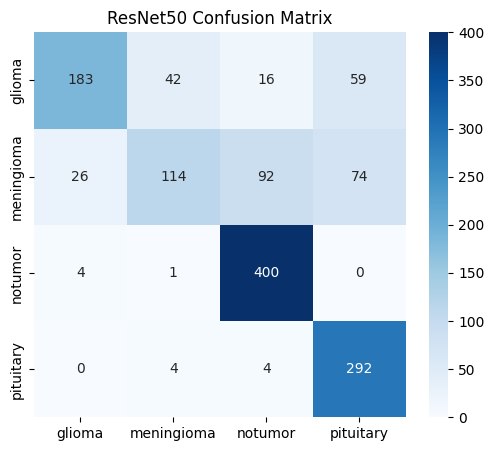

In [ ]:
#  STEP 8: Evaluation & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(name, model):
    pred = model.predict(test_gen)
    y_pred = np.argmax(pred, axis=1)
    y_true = test_gen.classes
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Save confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
    plt.title(f'{name} Confusion Matrix')
    plt.savefig(f"{save_dir}/{name}_conf_matrix.png")
    plt.show()
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, pred[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    return {
        "accuracy": report['accuracy'],
        "precision": np.mean([report[str(i)]['precision'] for i in range(num_classes)]),
        "recall": np.mean([report[str(i)]['recall'] for i in range(num_classes)]),
        "f1_score": np.mean([report[str(i)]['f1-score'] for i in range(num_classes)]),
        "roc_auc": roc_auc
    }

results = {}
for name, model in models_dict.items():
    print(f"Evaluating {name}")
    results[name] = evaluate_model(name, model)


In [ ]:

# STEP 9: Comparison Table and CSV
import pandas as pd

df_results = pd.DataFrame(results).T
df_results.to_csv(f"{save_dir}/model_comparison.csv")
print(df_results)


             accuracy  precision    recall  f1_score   roc_auc
MesResNet50  0.967963   0.967990  0.966224  0.966936  0.994879
CNN          0.787185   0.785717  0.771077  0.765936  0.810923
AlexNet      0.901602   0.907309  0.894047  0.896007  0.974383
VGG16        0.871091   0.866847  0.863744  0.860757  0.947878
ResNet50     0.754386   0.758885  0.735884  0.719900  0.863542


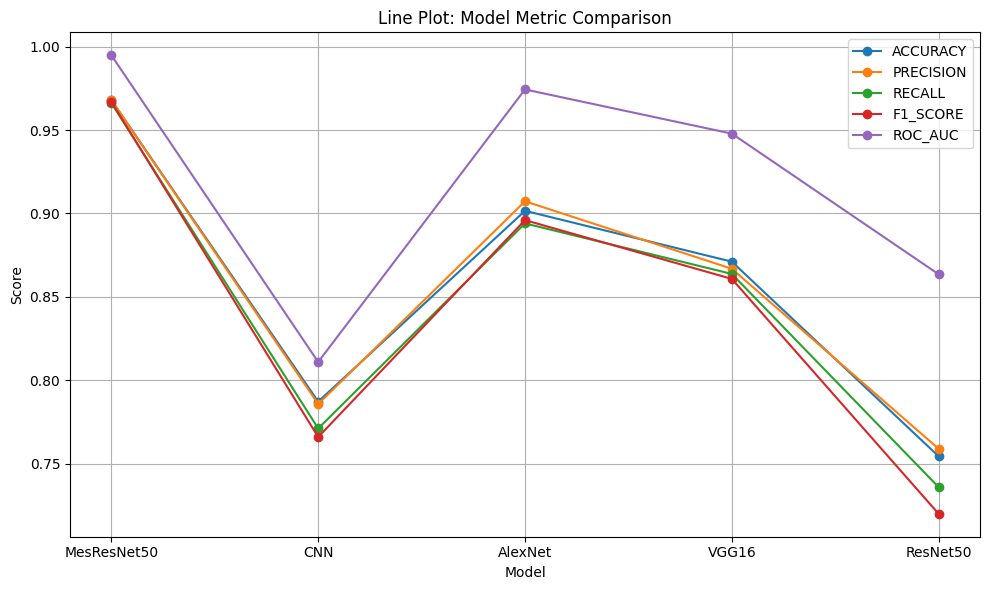

In [ ]:
# ✅ STEP 13: Line Plot for Accuracy, Precision, Recall, F1-Score, ROC AUC
metrics_list = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]

plt.figure(figsize=(10, 6))
for metric in metrics_list:
    plt.plot(df_results.index, df_results[metric], marker='o', label=metric.upper())

plt.title("Line Plot: Model Metric Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{save_dir}/lineplot_all_metrics.png")
plt.show()
plt.close()



41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step


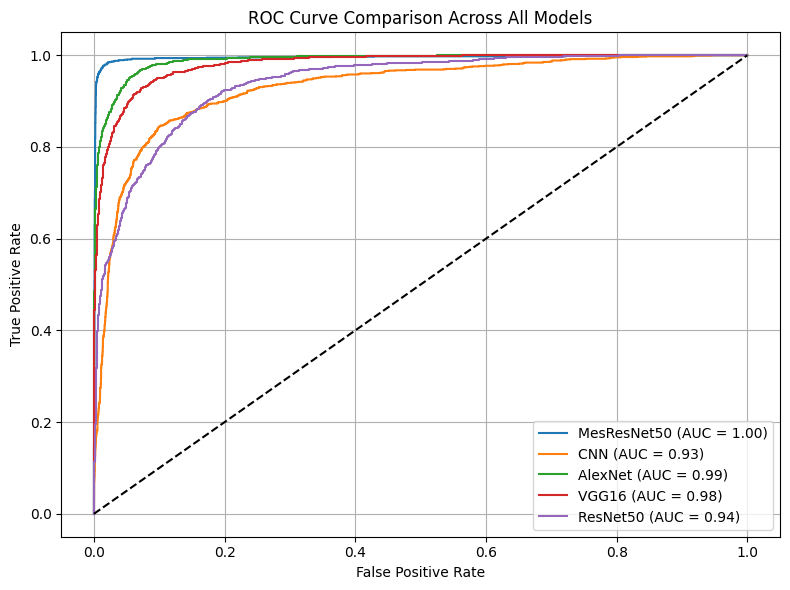

In [ ]:
# STEP 14: Combined ROC Curve for All Models
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class ROC
y_true_binarized = label_binarize(test_gen.classes, classes=list(range(num_classes)))

plt.figure(figsize=(8, 6))
for name, model in models_dict.items():
    y_pred = model.predict(test_gen)
    try:
        fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    except:
        print(f"Skipping {name} for ROC due to error in prediction shape.")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison Across All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{save_dir}/combined_roc_curve.png")
plt.show()
plt.close()


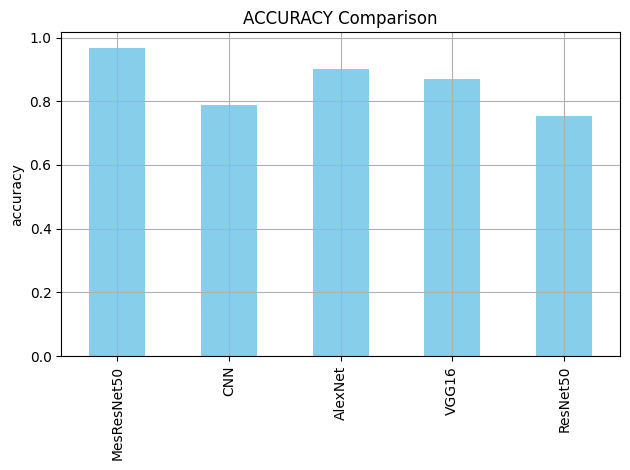

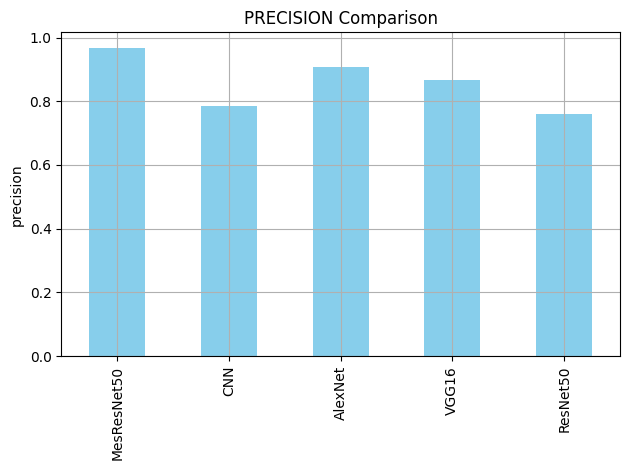

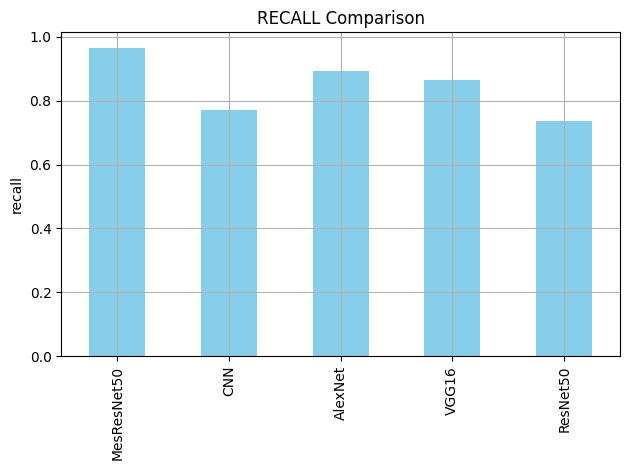

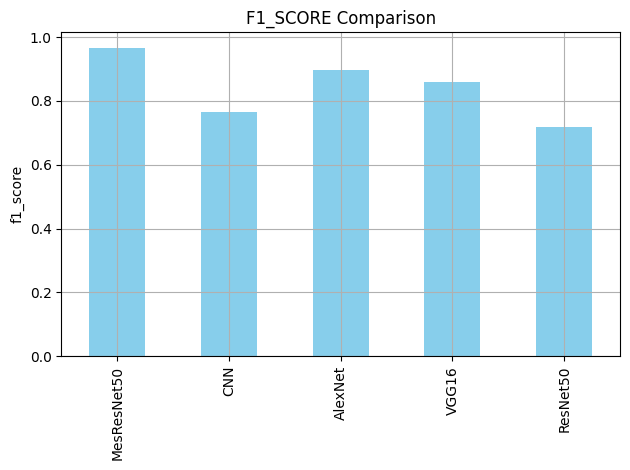

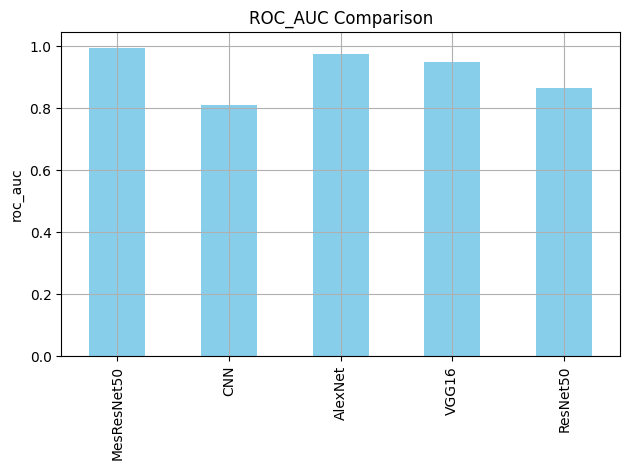

In [ ]:
# STEP 10: Graphs for All Metrics (Bar Charts)
for metric in ["accuracy", "precision", "recall", "f1_score", "roc_auc"]:
    plt.figure()
    df_results[metric].plot(kind='bar', title=f"{metric.upper()} Comparison", color='skyblue')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{metric}_comparison.png")
    plt.show()
    plt.close()


In [ ]:
# ✅ STEP 11: Grad-CAM Visualisation for MesResNet50
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model

def grad_cam_visualize(model, img_path, layer_name, output_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_outputs.shape[:2])
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, img_size)
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(img_array[0]*255), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, superimposed_img)

sample_img_path = test_gen.filepaths[0]
grad_cam_visualize(models_dict['MesResNet50'], sample_img_path, 'conv5_block3_out', f"{save_dir}/gradcam_mesresnet.png")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
# ✅ STEP 12: Save Architecture Comparison Diagram
from shutil import copyfile
copyfile('/content/A_comparison_chart_in_a_digital_image_visually_ana.png', f"{save_dir}/model_architecture_diagram.png")


FileNotFoundError: [Errno 2] No such file or directory: '/content/A_comparison_chart_in_a_digital_image_visually_ana.png'

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


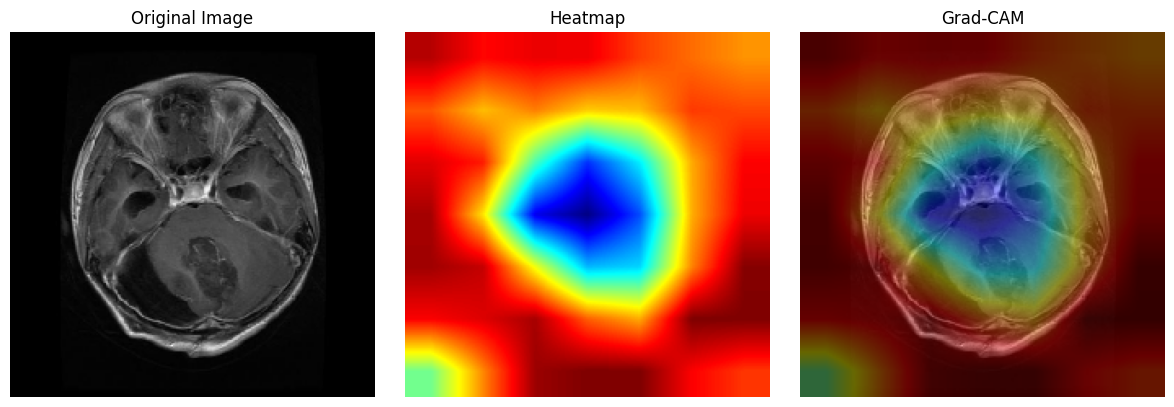

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam_visualize(model, img_path, layer_name, output_path, img_size=(224, 224), show=True):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Build grad model
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    # Compute channel-wise mean of gradients
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)  # normalize

    # Resize to match input
    cam_resized = cv2.resize(cam, img_size)

    # Apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

    # Save the output
    cv2.imwrite(output_path, superimposed_img)

    # Display images with labels
    if show:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3,


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os

def grad_cam_for_models(models_dict, img_path, layer_names, save_dir, img_size=(224, 224), show=True):
    """
    Generate and compare Grad-CAM overlays for multiple models.

    models_dict: dict -> { 'ModelName': model }
    img_path: str -> path to input image
    layer_names: dict -> { 'ModelName': 'last_conv_layer_name' }
    save_dir: str -> directory to save Grad-CAM images
    img_size: tuple -> input size for models
    """
    os.makedirs(save_dir, exist_ok=True)

    # Load and preprocess the input image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(5 * (len(models_dict) + 1), 5))

    # Show original image
    axes[0].imshow(img_array[0])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Iterate through models
    for idx, (model_name, model) in enumerate(models_dict.items(), start=1):
        layer_name = layer_names[model_name]

        grad_model = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_class = tf.argmax(predictions[0])
            loss = predictions[:, pred_class]

        grads = tape.gradient(loss, conv_outputs)[0]
        conv_outputs = conv_outputs[0]

        weights = tf.reduce_mean(grads, axis=(0, 1))
        cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * conv_outputs[:, :, i]

        cam = np.maximum(cam, 0)
        cam = cam / (np.max(cam) + 1e-8)

        cam_resized = cv2.resize(cam, img_size)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

        # Save image
        output_path = os.path.join(save_dir, f"gradcam_{model_name.lower()}.png")
        cv2.imwrite(output_path, superimposed_img)

        # Display
        axes[idx].imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
        axes[idx].set_title(f"{model_name}\nPred: {pred_class.numpy()}")
        axes[idx].axis("off")

    plt.tight_layout()
    if show:
        plt.show()

# Example usage:
# layer_names_map = {
#     'MesResNet50': 'conv5_block3_out',
#     'CNN': 'conv2d_1',   # replace with your CNN's last conv layer name
#     'VGG16': 'block5_conv3',
#     'AlexNet': 'conv2d_5' # replace with your AlexNet's last conv layer name
# }
# sample_img_path = test_gen.filepaths[0]
# grad_cam_for_models(models_dict, sample_img_path, layer_names_map, save_dir)


Generating Grad-CAM comparison for image:
/content/drive/MyDrive/alex/Brain/Testing/notumor/Te-no_0112.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


AttributeError: The layer sequential has never been called and thus has no defined output.

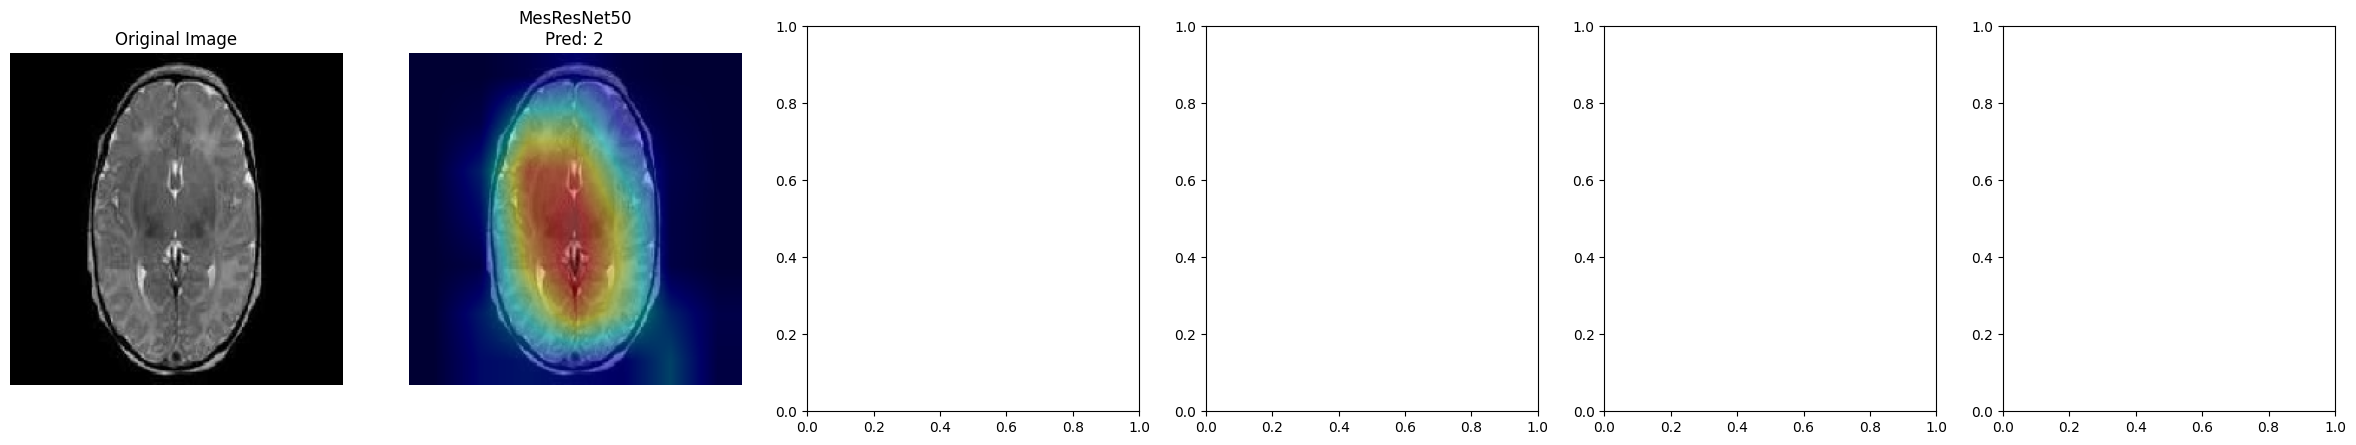

In [ ]:
# --- Grad-CAM Multi-Model Comparison ---
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import random

def grad_cam_for_models(models_dict, img_path, layer_names, save_dir, img_size=(224, 224), show=True):
    os.makedirs(save_dir, exist_ok=True)

    # Load and preprocess the input image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(5 * (len(models_dict) + 1), 5))

    # Show original image
    axes[0].imshow(img_array[0])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Iterate through models
    for idx, (model_name, model) in enumerate(models_dict.items(), start=1):
        # Explicitly build Sequential models if they haven't been built
        if not model.built:
            model.build(input_shape=(None, *img_size, 3))

        layer_name = layer_names[model_name]

        grad_model = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_class = tf.argmax(predictions[0])
            loss = predictions[:, pred_class]

        grads = tape.gradient(loss, conv_outputs)[0]
        conv_outputs = conv_outputs[0]

        weights = tf.reduce_mean(grads, axis=(0, 1))
        cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * conv_outputs[:, :, i]

        cam = np.maximum(cam, 0)
        cam = cam / (np.max(cam) + 1e-8)

        cam_resized = cv2.resize(cam, img_size)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

        # Save image
        output_path = os.path.join(save_dir, f"gradcam_{model_name.lower()}.png")
        cv2.imwrite(output_path, superimposed_img)

        # Display
        axes[idx].imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
        axes[idx].set_title(f"{model_name}\nPred: {pred_class.numpy()}")
        axes[idx].axis("off")

    plt.tight_layout()
    if show:
        plt.show()

# --- Run Grad-CAM comparison after training ---
# Map model names to their last convolutional layer
layer_names_map = {
    'MesResNet50': 'conv5_block3_out',
    'CNN': 'conv2d_1',       # change to your CNN's last conv layer
    'VGG16': 'block5_conv3',
    'AlexNet': 'conv2d_6'    # change to your AlexNet's last conv layer
}

# Pick a random test image
sample_img_path = random.choice(test_gen.filepaths)

print(f"Generating Grad-CAM comparison for image:\n{sample_img_path}")

grad_cam_for_models(models_dict, sample_img_path, layer_names_map, save_dir)

In [ ]:
from tensorflow.keras.layers import Conv2D

layer_names_map = {}

for model_name, model in models_dict.items():
    last_conv_layer_name = None
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            last_conv_layer_name = layer.name
    layer_names_map[model_name] = last_conv_layer_name

print("Last convolutional layers found:")
print(layer_names_map)


Last convolutional layers found:
{'MesResNet50': 'conv5_block3_3_conv', 'CNN': 'conv2d_1', 'AlexNet': 'conv2d_6', 'VGG16': None, 'ResNet50': None}


Generating Grad-CAM comparison for:
/content/drive/MyDrive/alex/Brain/Testing/meningioma/Te-me_0012.jpg
Detected last Conv2D layers: {'MesResNet50': 'conv5_block3_3_conv', 'CNN': 'conv2d_1', 'AlexNet': 'conv2d_6', 'VGG16': None, 'ResNet50': None}
Building model: CNN
Building model: AlexNet
Building model: VGG16
Building model: ResNet50


AttributeError: The layer sequential has never been called and thus has no defined output.

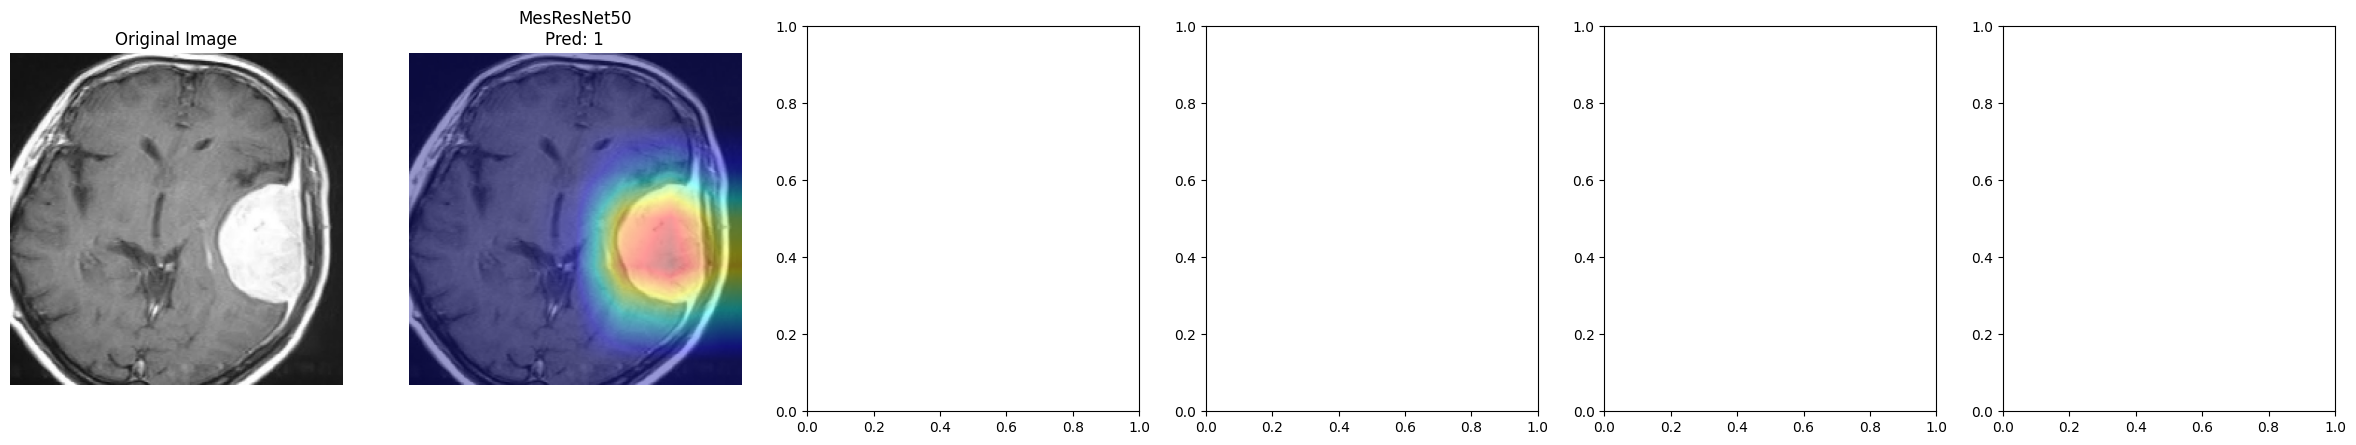

In [ ]:
# --- Grad-CAM Multi-Model Comparison with Auto-Build ---
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import os
import random

def get_last_conv_layers(models_dict):
    """Finds the last Conv2D layer name for each model."""
    layer_names_map = {}
    for model_name, model in models_dict.items():
        last_conv_layer_name = None
        for layer in model.layers:
            if isinstance(layer, Conv2D):
                last_conv_layer_name = layer.name
        layer_names_map[model_name] = last_conv_layer_name
    return layer_names_map

def grad_cam_for_models(models_dict, img_path, save_dir, img_size=(224, 224), show=True):
    """Generates Grad-CAM overlays for multiple models and compares them."""
    os.makedirs(save_dir, exist_ok=True)

    # Auto-detect last conv layer names
    layer_names = get_last_conv_layers(models_dict)
    print("Detected last Conv2D layers:", layer_names)

    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Auto-build models if not already built
    dummy_input = tf.random.normal((1, img_size[0], img_size[1], 3))
    for model_name, model in models_dict.items():
        try:
            _ = model.output  # Check if output is already defined
        except:
            print(f"Building model: {model_name}")
            model(dummy_input)

    # Plot comparison
    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(5 * (len(models_dict) + 1), 5))

    # Show original image
    axes[0].imshow(img_array[0])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Loop through models
    for idx, (model_name, model) in enumerate(models_dict.items(), start=1):
        layer_name = layer_names[model_name]

        grad_model = Model(inputs=[model.inputs],
                           outputs=[model.get_layer(layer_name).output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_class = tf.argmax(predictions[0])
            loss = predictions[:, pred_class]

        grads = tape.gradient(loss, conv_outputs)[0]
        conv_outputs = conv_outputs[0]

        weights = tf.reduce_mean(grads, axis=(0, 1))
        cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * conv_outputs[:, :, i]

        cam = np.maximum(cam, 0)
        cam = cam / (np.max(cam) + 1e-8)

        cam_resized = cv2.resize(cam, img_size)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

        # Save Grad-CAM overlay
        output_path = os.path.join(save_dir, f"gradcam_{model_name.lower()}.png")
        cv2.imwrite(output_path, superimposed_img)

        # Display Grad-CAM
        axes[idx].imshow(superimposed_img[..., ::-1])  # BGR → RGB
        axes[idx].set_title(f"{model_name}\nPred: {pred_class.numpy()}")
        axes[idx].axis("off")

    plt.tight_layout()
    if show:
        plt.show()

# --- Run Grad-CAM after training & evaluation ---
sample_img_path = random.choice(test_gen.filepaths)
print(f"Generating Grad-CAM comparison for:\n{sample_img_path}")

grad_cam_for_models(models_dict, sample_img_path, save_dir)



Available layers in model:
0: input_layer
1: conv1_pad
2: conv1_conv
3: conv1_bn
4: conv1_relu
5: pool1_pad
6: pool1_pool
7: conv2_block1_1_conv
8: conv2_block1_1_bn
9: conv2_block1_1_relu
10: conv2_block1_2_conv
11: conv2_block1_2_bn
12: conv2_block1_2_relu
13: conv2_block1_0_conv
14: conv2_block1_3_conv
15: conv2_block1_0_bn
16: conv2_block1_3_bn
17: conv2_block1_add
18: conv2_block1_out
19: conv2_block2_1_conv
20: conv2_block2_1_bn
21: conv2_block2_1_relu
22: conv2_block2_2_conv
23: conv2_block2_2_bn
24: conv2_block2_2_relu
25: conv2_block2_3_conv
26: conv2_block2_3_bn
27: conv2_block2_add
28: conv2_block2_out
29: conv2_block3_1_conv
30: conv2_block3_1_bn
31: conv2_block3_1_relu
32: conv2_block3_2_conv
33: conv2_block3_2_bn
34: conv2_block3_2_relu
35: conv2_block3_3_conv
36: conv2_block3_3_bn
37: conv2_block3_add
38: conv2_block3_out
39: conv3_block1_1_conv
40: conv3_block1_1_bn
41: conv3_block1_1_relu
42: conv3_block1_2_conv
43: conv3_block1_2_bn
44: conv3_block1_2_relu
45: conv3_

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


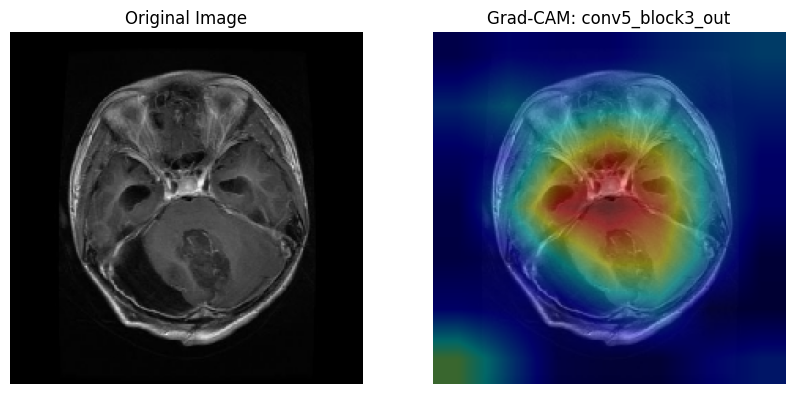

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def grad_cam_visualize(model, img_path, layer_name, output_path, img_size=(224, 224)):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Call the model once to ensure it's built
    _ = model(img_array)

    # Debug: Print all layer names
    print("\nAvailable layers in model:")
    for i, layer in enumerate(model.layers):
        print(f"{i}: {layer.name}")

    # Create Grad-CAM model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, img_size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, superimposed_img)

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array[0])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img[..., ::-1])
    plt.title(f"Grad-CAM: {layer_name}")
    plt.axis('off')

    plt.show()

# Example usage:
sample_img_path = test_gen.filepaths[0]
grad_cam_visualize(
    models_dict['MesResNet50'],
    sample_img_path,
    'conv5_block3_out',  # Change to your last conv layer name
    f"{save_dir}/gradcam_mesresnet.png"
)


Generating Grad-CAM for MesResNet50...


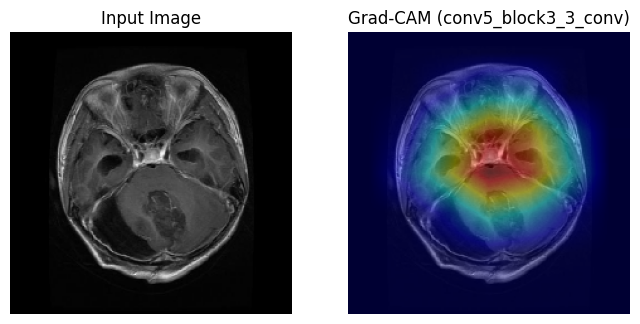

Generating Grad-CAM for CNN...


AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Function to find last convolutional layer in a model
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

# Grad-CAM visualization function
def grad_cam_visualize(model, img_path, output_path, img_size=(224, 224)):
    layer_name = get_last_conv_layer_name(model)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, img_size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, superimposed_img)

    # Display input and Grad-CAM
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.uint8(img_array[0] * 255))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM ({layer_name})")
    plt.axis("off")
    plt.show()

# Loop over all models in models_dict
sample_img_path = test_gen.filepaths[0]  # First test image
for model_name, model in models_dict.items():
    print(f"Generating Grad-CAM for {model_name}...")
    save_path = f"{save_dir}/gradcam_{model_name.lower()}.png"
    grad_cam_visualize(model, sample_img_path, save_path)


Using layer: conv5_block3_3_conv for Grad-CAM


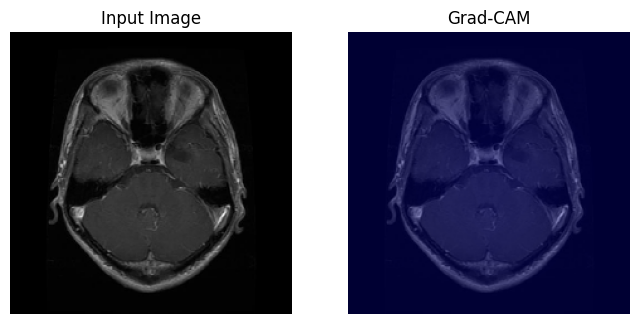

Using layer: conv2d_1 for Grad-CAM
Grad-CAM failed for CNN: The layer sequential has never been called and thus has no defined output.
Using layer: conv2d_6 for Grad-CAM
Grad-CAM failed for AlexNet: The layer sequential_1 has never been called and thus has no defined output.
Grad-CAM failed for VGG16: No Conv2D layer found in the model.
Grad-CAM failed for ResNet50: No Conv2D layer found in the model.


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Unified Grad-CAM function
def grad_cam_visualize_any(model, img_path, output_path, layer_name=None, img_size=(224, 224)):
    # Ensure model is built
    model(tf.zeros((1, *img_size, 3)))

    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # If no layer name is given, find last Conv2D layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
        if layer_name is None:
            raise ValueError("No Conv2D layer found in the model.")

    print(f"Using layer: {layer_name} for Grad-CAM")

    # Build model for Grad-CAM
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Weighted sum of activation maps
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam /= (np.max(cam) + 1e-8)

    # Resize CAM to image size
    cam = cv2.resize(cam, img_size)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, superimposed_img)

    # Display input and Grad-CAM
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()


# Example usage for all models
sample_img_path = test_gen.filepaths[1]

for model_name, model in models_dict.items():
    try:
        save_path = f"{save_dir}/gradcam_{model_name.lower()}.png"
        grad_cam_visualize_any(model, sample_img_path, save_path, layer_name=None, img_size=(224, 224))
    except Exception as e:
        print(f"Grad-CAM failed for {model_name}: {e}")


Sample image: /content/drive/MyDrive/alex/Brain/Testing/glioma/Te-glTr_0000.jpg
Using conv layer for Grad-CAM: conv5_block3_3_conv
Saved Grad-CAM overlay to: /content/drive/MyDrive/alex/brain_tumor_results/gradcam_mesresnet.png


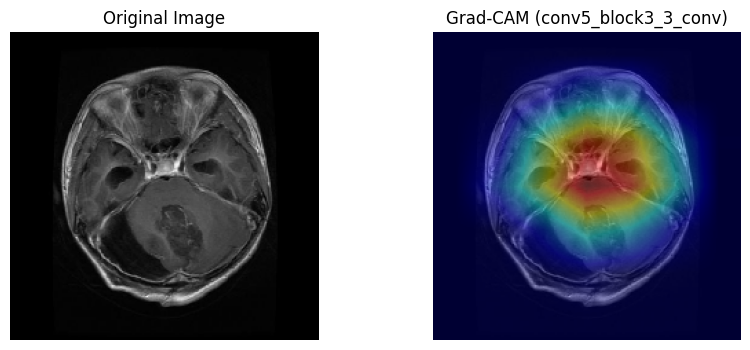

Using conv layer for Grad-CAM: conv2d_1
Failed to create grad_model with conv_layer.output and model.output.
This can happen if the conv layer's tensor is not connected to model inputs.
Grad-CAM failed for model: sequential
CNN failed: The layer sequential has never been called and thus has no defined output.
Using conv layer for Grad-CAM: conv2d_6
Failed to create grad_model with conv_layer.output and model.output.
This can happen if the conv layer's tensor is not connected to model inputs.
Grad-CAM failed for model: sequential_1
AlexNet failed: The layer sequential_1 has never been called and thus has no defined output.
Using conv layer for Grad-CAM: block5_conv3
Failed to create grad_model with conv_layer.output and model.output.
This can happen if the conv layer's tensor is not connected to model inputs.
Grad-CAM failed for model: sequential_2
VGG16 failed with preprocess; retrying without preprocess...
Using conv layer for Grad-CAM: block5_conv3
Failed to create grad_model with co

Traceback (most recent call last):
  File "/tmp/ipython-input-3582186859.py", line 85, in grad_cam_for_model
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
                                                                        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 288, in output
    return self._get_node_attribute_at_index(0, "output_tensors", "output")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 307, in _get_node_attribute_at_index
    raise AttributeError(
AttributeError: The layer sequential has never been called and thus has no defined output.
Traceback (most recent call last):
  File "/tmp/ipython-input-3582186859.py", line 85, in grad_cam_for_model
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
                                      

Using conv layer for Grad-CAM: conv5_block3_3_conv
Failed to create grad_model with conv_layer.output and model.output.
This can happen if the conv layer's tensor is not connected to model inputs.
Grad-CAM failed for model: sequential_3
ResNet50 failed with preprocess; retrying without preprocess...


Traceback (most recent call last):
  File "/tmp/ipython-input-3582186859.py", line 85, in grad_cam_for_model
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
                                                                        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 288, in output
    return self._get_node_attribute_at_index(0, "output_tensors", "output")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 307, in _get_node_attribute_at_index
    raise AttributeError(
AttributeError: The layer sequential_3 has never been called and thus has no defined output.


Using conv layer for Grad-CAM: conv5_block3_3_conv
Failed to create grad_model with conv_layer.output and model.output.
This can happen if the conv layer's tensor is not connected to model inputs.
Grad-CAM failed for model: sequential_3
ResNet50 fallback failed: The layer sequential_3 has never been called and thus has no defined output.


Traceback (most recent call last):
  File "/tmp/ipython-input-3582186859.py", line 204, in <cell line: 0>
    grad_cam_for_model(models_dict['ResNet50'],
  File "/tmp/ipython-input-3582186859.py", line 143, in grad_cam_for_model
    raise exc
  File "/tmp/ipython-input-3582186859.py", line 85, in grad_cam_for_model
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
                                                                        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 288, in output
    return self._get_node_attribute_at_index(0, "output_tensors", "output")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 307, in _get_node_attribute_at_index
    raise AttributeError(
AttributeError: The layer sequential_3 has never been called and thus has no defined output.

During handling of the 

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os, traceback

# -------------------------
# Helper: find last Conv2D (recursively)
# -------------------------
def find_last_conv_layer(model):
    """Return the layer object of the last Conv2D found anywhere inside the model (including nested models)."""
    all_layers = []
    def recurse(layer):
        all_layers.append(layer)
        # some layers (Models/Sequential) have .layers
        if hasattr(layer, "layers") and layer.layers:
            for child in layer.layers:
                recurse(child)
    recurse(model)
    # iterate reversed to find last Conv2D
    for layer in reversed(all_layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer
    return None

# -------------------------
# Main Grad-CAM function (robust)
# -------------------------
def grad_cam_for_model(model,
                       img_path,
                       save_path,
                       img_size=(224,224),
                       preprocess_fn=None,
                       layer_obj_override=None):
    """
    model: a compiled/trained Keras model (may be Sequential or Functional).
    img_path: path to input image (PIL readable).
    save_path: path where overlay image will be saved (PNG).
    img_size: (height, width)
    preprocess_fn: optional function to preprocess a batch (e.g., tf.keras.applications.vgg16.preprocess_input).
                   If provided, the raw image array should NOT be divided by 255 before passing to preprocess_fn.
    layer_obj_override: optionally pass a layer object (instead of auto-detect).
    """
    try:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

        # Load image (PIL -> RGB array)
        pil = load_img(img_path, target_size=img_size)
        orig_arr = img_to_array(pil).astype(np.uint8)  # shape (H,W,3), RGB

        # Prepare model input batch X for both build and forward
        if preprocess_fn is not None:
            X = np.expand_dims(orig_arr.copy(), axis=0).astype(np.float32)  # keep 0-255 as float for preprocess fn
            X = preprocess_fn(X)
        else:
            X = np.expand_dims(orig_arr.copy(), axis=0).astype(np.float32) / 255.0

        # Build model if needed (call once)
        try:
            # if model not built this will call it and define tensors
            _ = model.output
        except Exception:
            try:
                _ = model(X)
            except Exception:
                # try explicit build then call
                try:
                    model.build((None, img_size[0], img_size[1], 3))
                    _ = model(X)
                except Exception as e:
                    print("Error while trying to build/call the model:", e)
                    raise

        # Find conv layer (object)
        conv_layer = layer_obj_override or find_last_conv_layer(model)
        if conv_layer is None:
            raise ValueError("Could not find any Conv2D layer inside the model (searched recursively).")

        print(f"Using conv layer for Grad-CAM: {conv_layer.name}")

        # Create grad_model (outputs: conv activation, model output)
        try:
            grad_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])
        except Exception as e:
            print("Failed to create grad_model with conv_layer.output and model.output.")
            print("This can happen if the conv layer's tensor is not connected to model inputs.")
            raise

        # Compute gradients
        with tf.GradientTape() as tape:
            conv_outputs, preds = grad_model(tf.convert_to_tensor(X))
            # conv_outputs shape: (1, Hc, Wc, C)
            class_idx = tf.argmax(preds[0])
            loss = preds[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)   # shape (1, Hc, Wc, C)
        if grads is None:
            raise RuntimeError("GradientTape returned None for gradients (check model/tensors).")

        # Move to numpy
        conv_outputs = conv_outputs[0].numpy()
        grads = grads[0].numpy()

        # channel-wise weights: mean of gradients over spatial dims
        weights = np.mean(grads, axis=(0,1))       # shape (C,)

        # weighted combination of activation maps
        cam = np.sum(conv_outputs * weights[None, None, :], axis=-1)  # (Hc, Wc)
        cam = np.maximum(cam, 0)
        cam = cam / (np.max(cam) + 1e-8)

        # Resize CAM to input image size (cv2.resize expects (w,h))
        h, w = img_size
        cam_resized = cv2.resize(cam, (w, h))

        # Create heatmap and overlay (work in BGR for cv2 functions)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)      # BGR
        orig_bgr = cv2.cvtColor(orig_arr, cv2.COLOR_RGB2BGR)                           # to BGR
        overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap, 0.4, 0)

        # Save overlay (BGR)
        cv2.imwrite(save_path, overlay)
        print(f"Saved Grad-CAM overlay to: {save_path}")

        # Display side-by-side (input RGB and overlay in RGB)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(orig_arr)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM ({conv_layer.name})")
        plt.axis('off')
        plt.show()

    except Exception as exc:
        print("Grad-CAM failed for model:", getattr(model, 'name', 'unknown'))
        traceback.print_exc()
        raise exc

# -------------------------
# Example: run for each model (tailored)
# -------------------------
sample_img = test_gen.filepaths[0]   # or choose random.choice(test_gen.filepaths)
print("Sample image:", sample_img)

# (A) MesResNet50 (you said this already works). No special preprocess.
try:
    grad_cam_for_model(models_dict['MesResNet50'],
                       sample_img,
                       os.path.join(save_dir, 'gradcam_mesresnet.png'),
                       img_size=(224,224),
                       preprocess_fn=None)
except Exception as e:
    print("MesResNet50 failed:", e)

# (B) Your custom CNN (likely normalized 0-1 during training). No preprocess.
try:
    grad_cam_for_model(models_dict['CNN'],
                       sample_img,
                       os.path.join(save_dir, 'gradcam_cnn.png'),
                       img_size=(224,224),
                       preprocess_fn=None)
except Exception as e:
    print("CNN failed:", e)

# (C) AlexNet (custom implementation). No preprocess unless you used a special one.
try:
    grad_cam_for_model(models_dict['AlexNet'],
                       sample_img,
                       os.path.join(save_dir, 'gradcam_alexnet.png'),
                       img_size=(224,224),
                       preprocess_fn=None)
except Exception as e:
    print("AlexNet failed:", e)

# (D) VGG16 (if you used keras.applications.VGG16 with imagenet weights, use its preprocess)
try:
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    grad_cam_for_model(models_dict['VGG16'],
                       sample_img,
                       os.path.join(save_dir, 'gradcam_vgg16.png'),
                       img_size=(224,224),
                       preprocess_fn=vgg_preprocess)
except Exception as e:
    print("VGG16 failed with preprocess; retrying without preprocess...")
    try:
        # fallback: try without preprocess (if you trained VGG with /255.)
        grad_cam_for_model(models_dict['VGG16'],
                           sample_img,
                           os.path.join(save_dir, 'gradcam_vgg16_fallback.png'),
                           img_size=(224,224),
                           preprocess_fn=None)
    except Exception as e2:
        print("VGG16 fallback failed:", e2)

# (E) ResNet50 (same idea: ResNet preprocess if built from applications)
try:
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    grad_cam_for_model(models_dict['ResNet50'],
                       sample_img,
                       os.path.join(save_dir, 'gradcam_resnet50.png'),
                       img_size=(224,224),
                       preprocess_fn=resnet_preprocess)
except Exception as e:
    print("ResNet50 failed with preprocess; retrying without preprocess...")
    try:
        grad_cam_for_model(models_dict['ResNet50'],
                           sample_img,
                           os.path.join(save_dir, 'gradcam_resnet50_fallback.png'),
                           img_size=(224,224),
                           preprocess_fn=None)
    except Exception as e2:
        print("ResNet50 fallback failed:", e2)


Saving plots to: /content/drive/MyDrive/brain_tumor_visualizations
Saving plots to: /content/drive/MyDrive/brain_tumor_visualizations


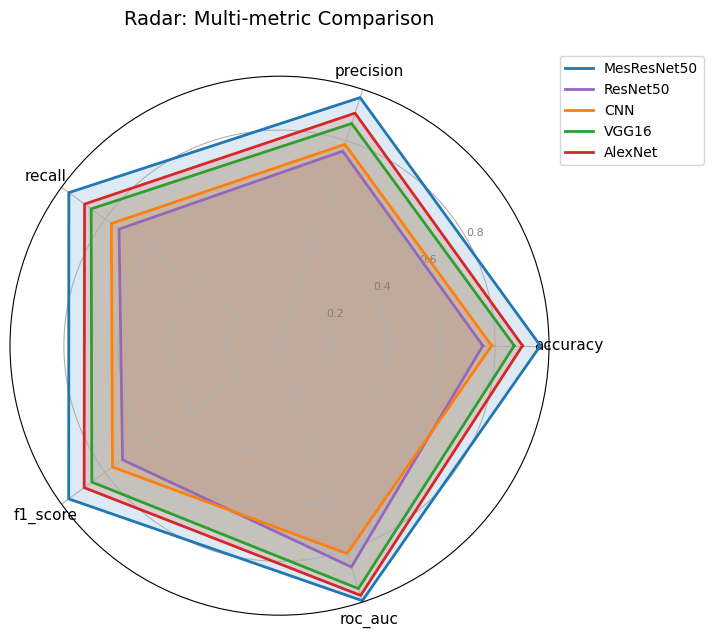

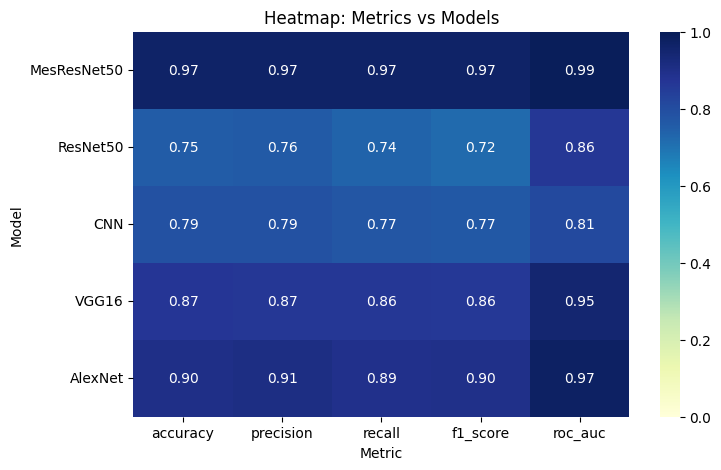

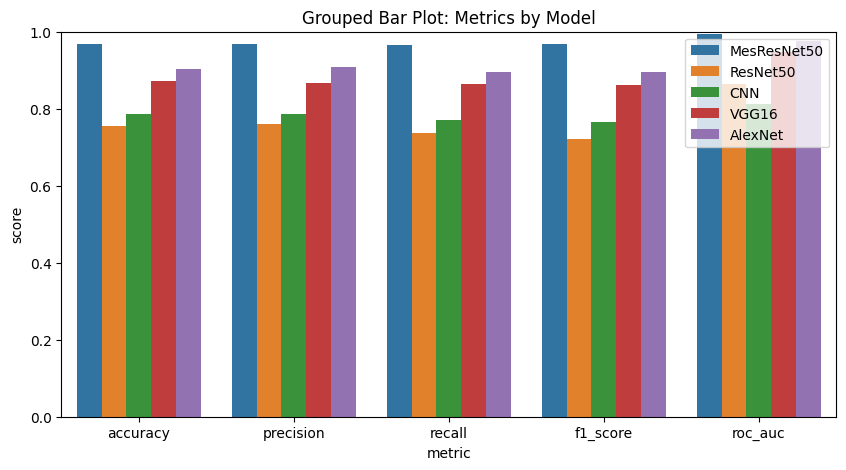

/tmp/ipython-input-3712721542.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df['precision'][i]+0.002, df['recall'][i]+0.002, idx, fontsize=9)


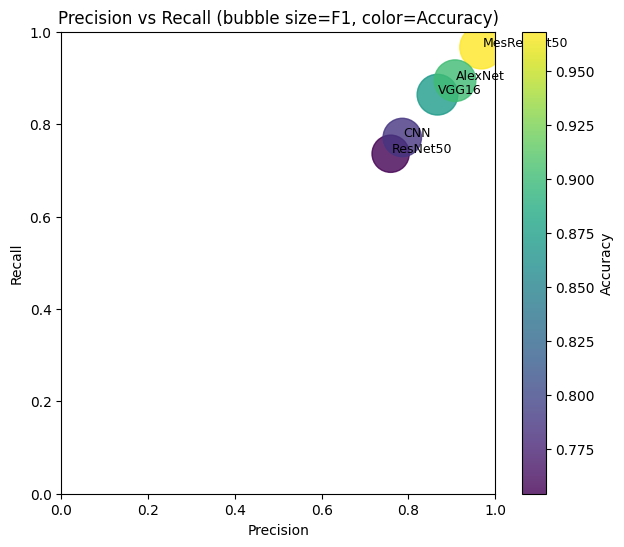

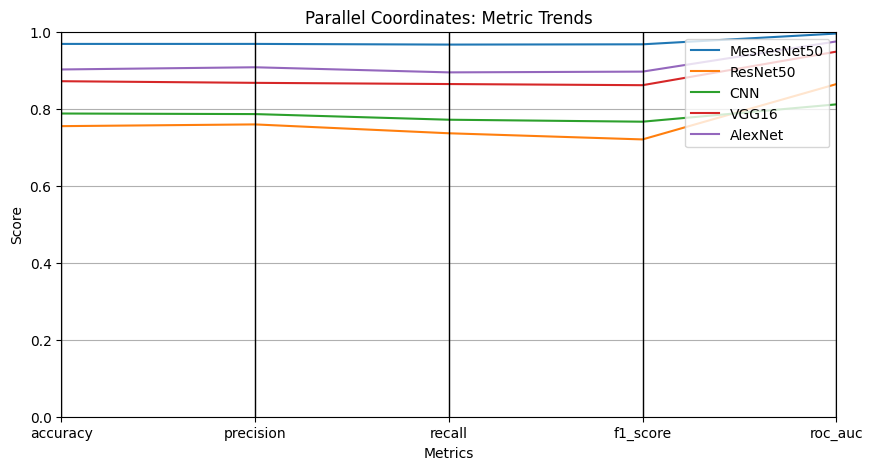

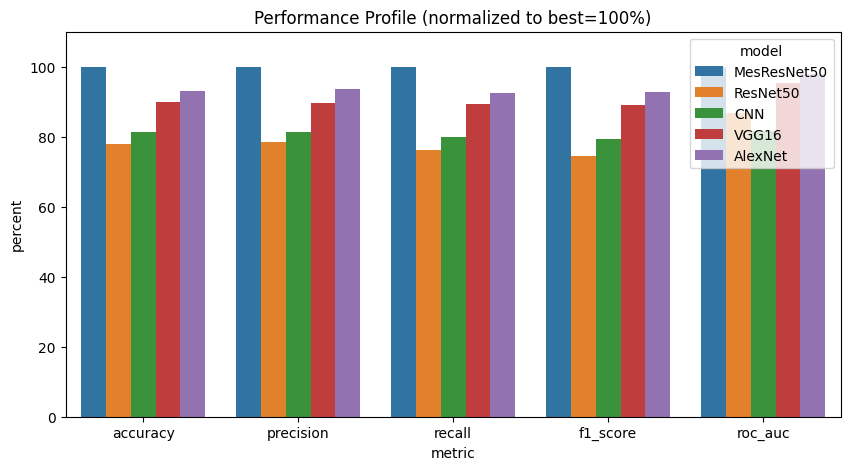

/tmp/ipython-input-3712721542.py:291: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.text(df['precision'][i]+0.002, df['recall'][i]+0.002, idx, fontsize=9)


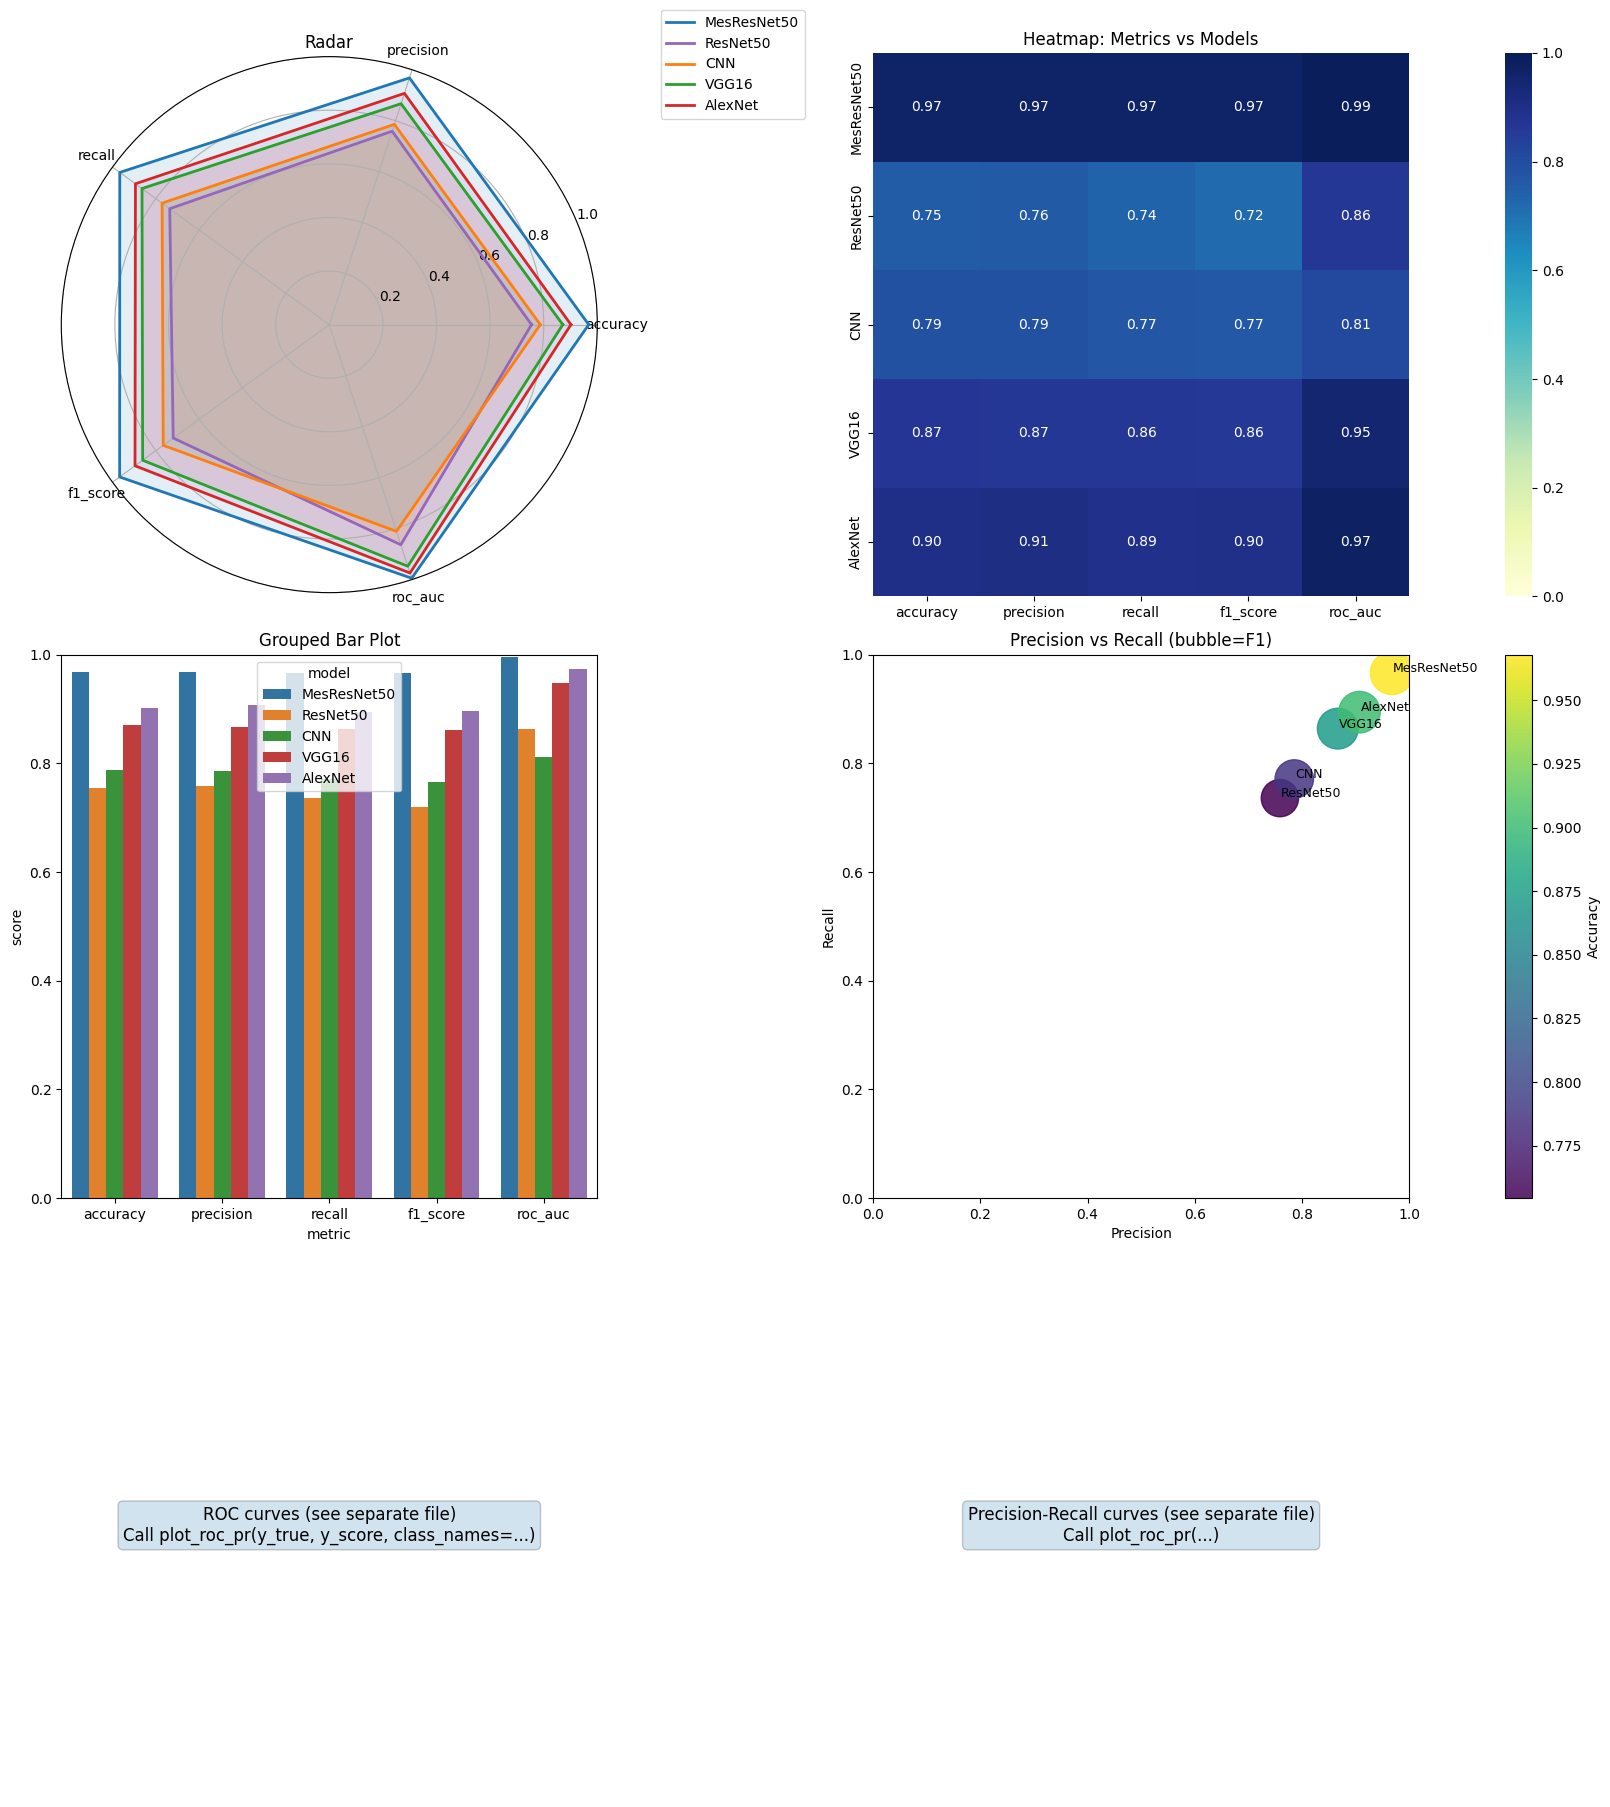

Saved composite dashboard to /content/drive/MyDrive/brain_tumor_visualizations/composite_dashboard.png
All plots generated.
Done. Check the output directory for plots.


In [ ]:
# Visualization dashboard for brain-tumor model comparison
# Run in Google Colab. Tested with Python 3.9+, matplotlib, seaborn, sklearn, pandas, numpy.

# Install missing packages if needed (uncomment)
# !pip install seaborn scikit-learn pandas numpy matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn import metrics
from sklearn.preprocessing import label_binarize

# Colab-specific: mount Google Drive (uncomment in Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# === CONFIG ===
DEFAULT_OUTPUT_DIR = "/content/drive/MyDrive/brain_tumor_visualizations"  # change if not Colab

# Create output dir
def prepare_output_dir(output_dir=DEFAULT_OUTPUT_DIR):
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving plots to: {output_dir}")
    return output_dir

# === INPUT FORMAT NOTES ===
# results_df: DataFrame indexed by model name, columns = ['accuracy','precision','recall','f1_score','roc_auc']
# Values should be floats in 0..1.
#
# cv_results (optional): dict where keys are metric names and values are DataFrames of shape (n_folds, n_models)
#    Example: cv_results['accuracy'] is a DataFrame with columns = model names and each row is a fold result.
#
# For ROC/PR curves (optional):
# - For binary classification:
#     y_true: array-like of shape (n_samples,) with 0/1 labels
#     y_score: array-like of shape (n_samples,) with probabilities for positive class
# - For multiclass:
#     y_true: array-like of shape (n_samples,) with integer labels 0..(n_classes-1)
#     y_score: array-like of shape (n_samples, n_classes) with predicted probabilities per class
#     class_names: list of class labels (strings) length n_classes

# === PLOTTING HELPERS ===

def radar_plot(results_df, models_colors=None, title="Radar: Multi-metric Comparison", savepath=None):
    """Radar chart for metrics in results_df (index=models, columns=metrics)."""
    metrics_list = list(results_df.columns)
    n_metrics = len(metrics_list)

    # Prepare angles
    angles = [n / float(n_metrics) * 2 * np.pi for n in range(n_metrics)]
    angles += angles[:1]

    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], metrics_list, fontsize=11)
    ax.set_rlabel_position(30)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    for i, model in enumerate(results_df.index):
        values = results_df.loc[model].tolist()
        values += values[:1]  # close polygon
        color = None
        if models_colors and model in models_colors:
            color = models_colors[model]
        ax.plot(angles, values, linewidth=2, label=model, color=color)
        ax.fill(angles, values, alpha=0.15, color=color)

    plt.title(title, y=1.08, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05))
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def heatmap_metrics(results_df, savepath=None, title="Heatmap: Metrics vs Models"):
    plt.figure(figsize=(8,5))
    sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Model")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def grouped_bar_plot(results_df, savepath=None, title="Grouped Bar Plot: Metrics by Model"):
    df = results_df.reset_index().melt(id_vars=results_df.index.name or 'index', var_name='metric', value_name='score')
    # If index name is None, reset_index created 'index' col name - handle that
    if df.columns[0] == 'index':
        df = df.rename(columns={'index':'model'})
    else:
        df = df.rename(columns={df.columns[0]:'model'})

    plt.figure(figsize=(10,5))
    sns.barplot(data=df, x='metric', y='score', hue='model')
    plt.ylim(0,1)
    plt.title(title)
    plt.legend(loc='upper right')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def bubble_precision_recall(results_df, savepath=None, title="Precision vs Recall (bubble size=F1, color=Accuracy)"):
    df = results_df.copy()
    plt.figure(figsize=(7,6))
    sc = plt.scatter(df['precision'], df['recall'], s=(df['f1_score']*1000), c=df['accuracy'], cmap='viridis', alpha=0.8)
    for i, idx in enumerate(df.index):
        plt.text(df['precision'][i]+0.002, df['recall'][i]+0.002, idx, fontsize=9)
    plt.xlabel('Precision'); plt.ylabel('Recall'); plt.title(title)
    cbar = plt.colorbar(sc)
    cbar.set_label('Accuracy')
    plt.xlim(0,1); plt.ylim(0,1)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def parallel_coordinates_plot(results_df, savepath=None, title="Parallel Coordinates: Metric Trends"):
    from pandas.plotting import parallel_coordinates
    df = results_df.reset_index().rename(columns={results_df.index.name or 'index':'model'})
    plt.figure(figsize=(10,5))
    parallel_coordinates(df, 'model', color=sns.color_palette("tab10", n_colors=len(df['model'])))
    plt.title(title)
    plt.ylim(0,1)
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def performance_profile(results_df, savepath=None, title="Performance Profile (normalized to best=100%)"):
    # Normalize each metric column so best = 100
    df = results_df.copy()
    norm = df / df.max() * 100
    norm = norm.reset_index().melt(id_vars=results_df.index.name or 'index', var_name='metric', value_name='percent')
    if norm.columns[0] == 'index':
        norm = norm.rename(columns={'index':'model'})
    else:
        norm = norm.rename(columns={norm.columns[0]:'model'})

    plt.figure(figsize=(10,5))
    sns.barplot(data=norm, x='metric', y='percent', hue='model')
    plt.title(title)
    plt.ylim(0,110)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def violin_cv(cv_results, savepath=None, title_prefix="CV Distribution"):
    # cv_results: dict metric -> DataFrame (n_folds x n_models)
    for metric, df in cv_results.items():
        plt.figure(figsize=(8,5))
        sns.violinplot(data=df)
        plt.title(f"{title_prefix}: {metric}")
        plt.ylabel(metric)
        plt.ylim(0,1)
        if savepath:
            fname = os.path.join(savepath, f"violin_{metric}.png")
            plt.savefig(fname, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

# ROC and PR functions
def plot_roc_pr(y_true, y_score, models_names=None, class_names=None, savepath=None):
    """
    Flexible ROC/PR plotting:
    - If multiclass (y_score shape = n_samples x n_classes): compute one-vs-rest ROC for each class and macro average.
    - If binary (y_score shape = n_samples,) or (n_samples,1): compute single ROC / PR.
    """
    # determine binary vs multiclass
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # binary case
    if y_score.ndim == 1 or (y_score.ndim == 2 and y_score.shape[1] == 1):
        if y_score.ndim == 2:
            y_score = y_score.ravel()
        fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
        auc = metrics.roc_auc_score(y_true, y_score)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1],[0,1],'k--',alpha=0.4)
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        if savepath:
            plt.savefig(os.path.join(savepath, "roc_binary.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        precision, recall, _ = metrics.precision_recall_curve(y_true, y_score)
        ap = metrics.average_precision_score(y_true, y_score)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, label=f"AP = {ap:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
        plt.legend()
        if savepath:
            plt.savefig(os.path.join(savepath, "pr_binary.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    else:
        # multiclass
        n_classes = y_score.shape[1]
        if class_names is None:
            class_names = [f"Class {i}" for i in range(n_classes)]
        # Binarize y_true
        y_bin = label_binarize(y_true, classes=list(range(n_classes)))

        # ROC per class
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            fpr, tpr, _ = metrics.roc_curve(y_bin[:, i], y_score[:, i])
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1],'k--', alpha=0.4)
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("Multiclass ROC Curves")
        plt.legend(loc='lower right')
        if savepath:
            plt.savefig(os.path.join(savepath, "roc_multiclass.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # PR per class
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            precision, recall, _ = metrics.precision_recall_curve(y_bin[:, i], y_score[:, i])
            ap = metrics.average_precision_score(y_bin[:, i], y_score[:, i])
            plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title("Precision-Recall Curves (per class)")
        plt.legend(loc='lower left')
        if savepath:
            plt.savefig(os.path.join(savepath, "pr_multiclass.png"), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

# Composite figure
def composite_figure(results_df, output_dir, models_colors=None):
    """Arranges radar, heatmap, grouped bar, bubble, ROC and PR (if present) into a single composite figure."""
    # Create a 3x2 composite layout
    fig = plt.figure(constrained_layout=True, figsize=(16,18))
    gs = fig.add_gridspec(3,2)

    # Panel 1: radar (we'll draw radar into axes)
    ax0 = fig.add_subplot(gs[0,0], polar=True)
    metrics_list = list(results_df.columns)
    n_metrics = len(metrics_list)
    angles = [n / float(n_metrics) * 2 * np.pi for n in range(n_metrics)]
    angles += angles[:1]
    ax0.set_xticks(angles[:-1])
    ax0.set_xticklabels(metrics_list)
    ax0.set_ylim(0,1)
    for model in results_df.index:
        values = results_df.loc[model].tolist()
        values += values[:1]
        ax0.plot(angles, values, linewidth=2, label=model, color=(models_colors.get(model) if models_colors else None))
        ax0.fill(angles, values, alpha=0.12)
    ax0.set_title("Radar")
    ax0.legend(loc='upper right', bbox_to_anchor=(1.4,1.1))

    # Panel 2: heatmap
    ax1 = fig.add_subplot(gs[0,1])
    sns.heatmap(results_df, annot=True, fmt=".2f", vmin=0, vmax=1, cmap="YlGnBu", ax=ax1)
    ax1.set_title("Heatmap: Metrics vs Models")

    # Panel 3: grouped bar
    ax2 = fig.add_subplot(gs[1,0])
    df_bar = results_df.reset_index().melt(id_vars=results_df.index.name or 'index', var_name='metric', value_name='score')
    if df_bar.columns[0] == 'index':
        df_bar = df_bar.rename(columns={'index':'model'})
    else:
        df_bar = df_bar.rename(columns={df_bar.columns[0]:'model'})
    sns.barplot(data=df_bar, x='metric', y='score', hue='model', ax=ax2)
    ax2.set_ylim(0,1)
    ax2.set_title("Grouped Bar Plot")

    # Panel 4: bubble
    ax3 = fig.add_subplot(gs[1,1])
    df = results_df.copy()
    sc = ax3.scatter(df['precision'], df['recall'], s=(df['f1_score']*1000), c=df['accuracy'], cmap='viridis', alpha=0.85)
    for i, idx in enumerate(df.index):
        ax3.text(df['precision'][i]+0.002, df['recall'][i]+0.002, idx, fontsize=9)
    ax3.set_xlim(0,1); ax3.set_ylim(0,1)
    ax3.set_xlabel('Precision'); ax3.set_ylabel('Recall'); ax3.set_title("Precision vs Recall (bubble=F1)")
    plt.colorbar(sc, ax=ax3, label='Accuracy')

    # Panel 5 & 6: placeholders for ROC and PR - if corresponding files exist in output_dir, we load them as images.
    # (Instead of embedding computed curves here which may require raw scores)
    # We'll just add text boxes indicating to include ROC/PR or leave blank.
    ax4 = fig.add_subplot(gs[2,0])
    ax4.axis('off')
    ax4.text(0.5,0.5, "ROC curves (see separate file)\nCall plot_roc_pr(y_true, y_score, class_names=...)", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round", alpha=0.2))

    ax5 = fig.add_subplot(gs[2,1])
    ax5.axis('off')
    ax5.text(0.5,0.5, "Precision-Recall curves (see separate file)\nCall plot_roc_pr(...)", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round", alpha=0.2))

    outpath = os.path.join(output_dir, "composite_dashboard.png")
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved composite dashboard to {outpath}")

# === MAIN GENERATOR FUNCTION ===
def generate_all_plots(results_df,
                       output_dir=DEFAULT_OUTPUT_DIR,
                       models_colors=None,
                       cv_results=None,
                       y_true=None,
                       y_score=None,
                       class_names=None):
    """
    Generate and save all visualizations.
    - results_df: DataFrame indexed by model names, columns=['accuracy','precision','recall','f1_score','roc_auc']
    - cv_results: optional dict metric -> DataFrame (n_folds x n_models)
    - y_true, y_score: optional for ROC/PR plotting
    - class_names: optional list for multiclass labels
    """
    output_dir = prepare_output_dir(output_dir)

    # Default colors
    default_colors = {
        "MesResNet50":"#1f77b4",
        "ResNet50":"#9467bd",
        "CNN":"#ff7f0e",
        "VGG16":"#2ca02c",
        "AlexNet":"#d62728"
    }
    if models_colors is None:
        models_colors = default_colors

    # Save individual plots
    radar_plot(results_df, models_colors=models_colors, savepath=os.path.join(output_dir, "radar.png"))
    heatmap_metrics(results_df, savepath=os.path.join(output_dir, "heatmap.png"))
    grouped_bar_plot(results_df, savepath=os.path.join(output_dir, "grouped_bar.png"))
    bubble_precision_recall(results_df, savepath=os.path.join(output_dir, "bubble_pr.png"))
    parallel_coordinates_plot(results_df, savepath=os.path.join(output_dir, "parallel_coordinates.png"))
    performance_profile(results_df, savepath=os.path.join(output_dir, "performance_profile.png"))

    # Violin plots from CV (if provided)
    if cv_results:
        violin_cv(cv_results, savepath=output_dir)

    # ROC/PR if raw scores provided
    if (y_true is not None) and (y_score is not None):
        plot_roc_pr(y_true, y_score, class_names=class_names, savepath=output_dir)

    # Composite
    composite_figure(results_df, output_dir, models_colors=models_colors)

    print("All plots generated.")

# === EXAMPLE USAGE ===
if __name__ == "__main__":
    # Example results (fill with your actual results)
    models = ["MesResNet50","ResNet50","CNN","VGG16","AlexNet"]
    sample_vals = {
        'accuracy':[ 0.967963, 0.754386   , 0.787185   , 0.871091   , 0.901602   ],
        'precision':[ 0.967990  , 0.758885  , 0.785717  , 0.866847  , 0.907309  ],
        'recall':[ 0.966224  , 0.735884  , 0.771077  , 0.863744  , 0.894047  ],
        'f1_score':[ 0.966936  , 0.719900  , 0.765936  , 0.860757  , 0.896007  ],
        'roc_auc':[ 0.994879, 0.863542, 0.810923, 0.947878, 0.974383]
    }
    results_df = pd.DataFrame(sample_vals, index=models)

    # Example CV results (optional)
    # cv_results = {
    #   'accuracy': pd.DataFrame(np.random.rand(5,5), columns=models),
    #   'f1_score': pd.DataFrame(np.random.rand(5,5), columns=models)
    # }

    # Example synthetic multiclass scores (if you want to test ROC/PR)
    # n = 200
    # n_classes = 4
    # rng = np.random.RandomState(0)
    # y_true = rng.randint(0, n_classes, size=n)
    # y_score = rng.rand(n, n_classes)
    # class_names = ['glioma','meningioma','pituitary','healthy']

    outdir = prepare_output_dir()  # change path if you want
    generate_all_plots(results_df, output_dir=outdir, cv_results=None, y_true=None, y_score=None)

    print("Done. Check the output directory for plots.")


In [ ]:
# ✅ STEP 15: Display all Confusion Matrices side-by-side
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

n_models = len(models_dict)
cols = 3 # Number of columns for subplots
rows = (n_models + cols - 1) // cols # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, (name, model) in enumerate(models_dict.items()):
    ax = axes[i]
    print(f"Generating confusion matrix for {name}")
    # Ensure test_gen is reset to the beginning for each model evaluation
    test_gen.reset()
    pred = model.predict(test_gen)
    y_pred = np.argmax(pred, axis=1)
    y_true = test_gen.classes
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys(),
                ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

NameError: name 'models_dict' is not defined